<a href="https://colab.research.google.com/github/SinhaBobby/Bone_Fracture_Classification/blob/main/Bone_Fracture_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision
from torchvision import transforms

from torchvision.datasets.utils import download_url
import zipfile
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torchvision.transforms import v2
from torch.utils.data import Dataset, DataLoader


In [23]:
project_name  = "Bone Fracture"
dataset_url = "https://www.kaggle.com/api/v1/datasets/download/pkdarabi/bone-break-classification-image-dataset"
download_url(dataset_url,'.')

Using downloaded and verified file: ./bone-break-classification-image-dataset


In [24]:
with zipfile.ZipFile("/content/bone-break-classification-image-dataset", 'r') as zip_ref:
    zip_ref.extractall('.')

In [25]:
def collect_image_paths(data_dir):
  data = []
  for folder_classes in os.listdir(data_dir):
    class_path = os.path.join(data_dir,folder_classes)
    print(class_path)
    if os.path.isdir(class_path):
      for split in ['Train','Test']:
        split_path = os.path.join(class_path,split)
        print(split_path)
        if os.path.isdir(split_path):
          for image_path in os.listdir(split_path):
            image_path = os.path.join(split_path,image_path)
            data.append({
                'path' :image_path,
                'target' :folder_classes,
                'split' :split})

  return data



In [26]:
dataset=collect_image_paths("/content/Bone Break Classification/Bone Break Classification")
df=pd.DataFrame(dataset)
df.head()

/content/Bone Break Classification/Bone Break Classification/Oblique fracture
/content/Bone Break Classification/Bone Break Classification/Oblique fracture/Train
/content/Bone Break Classification/Bone Break Classification/Oblique fracture/Test
/content/Bone Break Classification/Bone Break Classification/Longitudinal fracture
/content/Bone Break Classification/Bone Break Classification/Longitudinal fracture/Train
/content/Bone Break Classification/Bone Break Classification/Longitudinal fracture/Test
/content/Bone Break Classification/Bone Break Classification/Comminuted fracture
/content/Bone Break Classification/Bone Break Classification/Comminuted fracture/Train
/content/Bone Break Classification/Bone Break Classification/Comminuted fracture/Test
/content/Bone Break Classification/Bone Break Classification/Avulsion fracture
/content/Bone Break Classification/Bone Break Classification/Avulsion fracture/Train
/content/Bone Break Classification/Bone Break Classification/Avulsion fractur

,path,target,split
0,/content/Bone Break Classification/Bone Break ...,Oblique fracture,Train
1,/content/Bone Break Classification/Bone Break ...,Oblique fracture,Train
2,/content/Bone Break Classification/Bone Break ...,Oblique fracture,Train
3,/content/Bone Break Classification/Bone Break ...,Oblique fracture,Train
4,/content/Bone Break Classification/Bone Break ...,Oblique fracture,Train


In [27]:
import sklearn
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df['target']=le.fit_transform(df['target'])

In [28]:
import torch.utils.data as data_utils
train_df = pd.DataFrame(df[df['split']=='Train'])
tests_df = pd.DataFrame(df[df['split']=='Test'])

train_df.drop('split',axis=1,inplace=True)
tests_df.drop('split',axis=1,inplace=True)



In [29]:
transform = transforms.Compose([transforms.Resize((250,250)),
    transforms.ToTensor()
])

transform  = {
    'Train' : v2.Compose([
    v2.PILToTensor(),
    v2.RandomHorizontalFlip(p=.5),
    v2.RandomResizedCrop(size=[250, 250], antialias=True),
    v2.ToDtype(torch.float32, scale=True)]),

    'Test' : v2.Compose([
    v2.PILToTensor(),
    v2.RandomResizedCrop(size=[250, 250], antialias=True),
    v2.ToDtype(torch.float32, scale=True)])
}

In [30]:
class dataset(Dataset):
  def __init__(self,paths,labels=None,transform = None,isTrain = True):
    self.paths = paths.to_list()
    self.labels = labels.to_list()
    self.transform = transform
    self.isTrain= isTrain

  def __getitem__(self,index):
    image = Image.open(self.paths[index])
    if self.transform is not None:
      if self.isTrain:
        image = self.transform['Train'](image)
      else:
        image = self.transform['Test'](image)
    return image, self.labels[index]

  def __len__(self):
    return len(self.paths)


In [31]:
train_dataset = dataset(train_df['path'], train_df['target'], transform=transform,isTrain=True)
test_dataset = dataset(tests_df['path'], tests_df['target'], transform=transform,isTrain=False)

In [27]:
for img,label in test_dataset:
  print(img.shape)
  break

torch.Size([3, 250, 250])


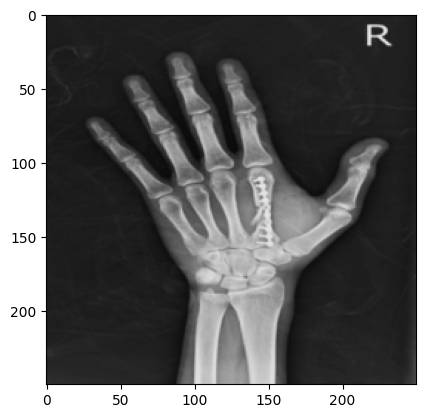

In [92]:
for img,label in train_dataset:
  plt.imshow(img.permute(1,2,0))
  break

In [32]:
train_loader = DataLoader(train_dataset, shuffle=True, batch_size =16)
test_loader = DataLoader(test_dataset, shuffle=True, batch_size =16)

In [33]:
class ImageClassificationBase(nn.Module):
  def training_step(self,batch):
    images,labels = batch
    out = self(images)
    _,pred = torch.max(out,dim=1)
    #print('in training',out, pred,labels)
    loss= F.cross_entropy(out,labels)
    return loss

  def validation_step(self, batch):
    images,labels=batch
    out=self(images)
    loss= F.cross_entropy(out,labels)
    acc= accuracy(out,labels)
    return {'val_loss':loss.detach(),'val_acc':acc}

  def validation_epoch_end(self, outputs):
    batch_losses= [x['val_loss'] for x in outputs]
    epoch_loss= torch.stack(batch_losses).mean()
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_accs= torch.stack(batch_accs).mean()
    return {'val_loss':epoch_loss.item(),'val_acc':epoch_accs.item()}

  def epoch_end(self,epoch, result):
    print("Epoch [{}],Train loss: {:.4f}, val_loss: {:,.4f}, val_acc: {:,.4f}".format(epoch,result['train_loss'],result['val_loss'],result['val_acc']))

def accuracy(outputs, labels):
  _,pred = torch.max(outputs,dim=1)# here max() function returns max value in the row(as dim=1) with its indices
  return torch.tensor(torch.sum(pred==labels).item()/len(outputs))




In [34]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device("cuda")
  else:
    return torch.device('cpu')

def to_Device(data,device):
  if isinstance(data,(list,tuple)):
    return [to_Device(x,device) for x in data]
  return data.to(device,non_blocking=True)

class DeviceDataLoader():
  #wrap a dataloader to move data to device#
  def __init__(self, dl, device):
    self.dl = dl
    self.device=device

  def __iter__(self):
    #yield a batch of data after moving it to device
    for b in self.dl:
      yield to_Device(b,self.device)


  def __len__(self):
    #number of batches
    return len(self.dl)

In [35]:
def conv_block(in_channels,out_channels,is_pool=False,):
  layers = [nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)]
  if is_pool:
    layers.append(nn.MaxPool2d(2))
  return nn.Sequential(*layers)

class Resnet9(ImageClassificationBase):
  def __init__(self,in_channels,num_classes):
    super().__init__()
    #input 3*250*20
    self.conv1 = conv_block(in_channels,64) #64*250*250
    self.conv2 = conv_block(64,128,is_pool=True)#128*125*125
    self.res1 = nn.Sequential(conv_block(128,128),conv_block(128,128))# 128*125*125

    self.conv3 = conv_block(128,256) # 256*125*125
    self.conv4 = conv_block(256,512,is_pool=True) # 512*62*62
    self.res2 = nn.Sequential(conv_block(512,512),conv_block(512,512)) # 512*62*62

    self.classifier = nn.Sequential(nn.MaxPool2d(4),#512*15*15
                                    nn.Flatten(),
                                    nn.Linear(512*15*15,num_classes))

  def forward(self,xb):
    out = self.conv1(xb)
    out = self.conv2(out)
    out = self.res1(out) + out
    out = self.conv3(out)
    out = self.conv4(out)
    out = self.res2(out) + out
    out = self.classifier(out)
    return out




In [36]:
device= get_default_device()
device
model = Resnet9(3,10)
num_epochs=30
opt_fun =  torch.optim.SGD
lr=0.01

In [37]:
model

Resnet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [38]:
train_dl = DeviceDataLoader(train_loader,device)
val_dl= DeviceDataLoader(test_loader,device)
#test_dl = DeviceDataLoader(test_dl,device)
to_Device(model,device)

Resnet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [39]:
@torch.no_grad()
def evaluate(model,val_loader):
  model.eval()
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs,max_lr,model,train_loader,val_loader,weight_decay=0,grad_clip=None,opt_func=torch.optim.SGD):
  torch.cuda.empty_cache()
  history=[]
  #setup custom optimizer with weight decay
  optimizer = opt_func(model.parameters(),max_lr,weight_decay=weight_decay)

  #set up one cycle learning rate scheduler
  sched = torch.optim.lr_scheduler.OneCycleLR(optimizer,max_lr,epochs=epochs,steps_per_epoch=len(train_loader))

  for epoch in range(epochs):
    #training phase
    model.train()
    train_losses=[]
    lrs =[]
    for batch in train_loader:
      loss = model.training_step(batch)
      train_losses.append(loss)
      loss.backward()

      #gradient clipping
      if grad_clip:
        nn.utils.clip_grad_value_(model.parameters(),grad_clip)

      optimizer.step()
      optimizer.zero_grad()

      #record and update learning rate
      lrs.append(get_lr(optimizer))

      sched.step()

    #validation phase
    result = evaluate(model,val_loader)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    #print(np.mean(lrs))
    model.epoch_end(epoch,result)
    history.append(result)
  return history




def fit(epochs,lr,model,train_loader,val_loader,opt_func):
  history=[]
  optimizer = opt_func(model.parameters(),lr)
  for epoch in range(num_epochs):
    model.train()
    train_losses = []

    for batch in train_dl:
      loss = model.training_step(batch)
      train_losses.append(loss)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    result = evaluate(model,val_loader)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    model.epoch_end(epoch,result)
    history.append(result)
  return history



      #forward pass



      #batch_output_res = torch.max(batch_output,1)
      #print(batch_output_res.shape,Batch_label.shape)

      #Batch_label = Batch_label.reshape(batch_output_res.shape)
      #Batch_label =  Batch_label.float()
      #batch_output = batch_output.type(torch.float32)









In [40]:
torch.cuda.empty_cache()
ini_his= evaluate(model,val_dl)

In [21]:
torch.cuda.empty_cache()
history = fit(epochs=num_epochs,lr=lr,model=model,train_loader=train_dl,val_loader=val_dl,opt_func=opt_fun)

Epoch [0],Train loss: 163.5166, val_loss: 18.4485, val_acc: 0.1389
Epoch [1],Train loss: 40.8386, val_loss: 39.1553, val_acc: 0.1111
Epoch [2],Train loss: 11.4962, val_loss: 5.4125, val_acc: 0.1042
Epoch [3],Train loss: 4.0204, val_loss: 3.9558, val_acc: 0.1250
Epoch [4],Train loss: 2.8535, val_loss: 2.8650, val_acc: 0.1435
Epoch [5],Train loss: 2.5394, val_loss: 2.5256, val_acc: 0.1389
Epoch [6],Train loss: 2.4107, val_loss: 2.3483, val_acc: 0.1806
Epoch [7],Train loss: 2.3085, val_loss: 2.3851, val_acc: 0.1528
Epoch [8],Train loss: 2.3149, val_loss: 2.5310, val_acc: 0.1319
Epoch [9],Train loss: 2.2913, val_loss: 2.4211, val_acc: 0.1505
Epoch [10],Train loss: 2.2552, val_loss: 2.3489, val_acc: 0.1597
Epoch [11],Train loss: 2.2461, val_loss: 2.4605, val_acc: 0.0903
Epoch [12],Train loss: 2.2360, val_loss: 2.3122, val_acc: 0.1088
Epoch [13],Train loss: 2.2374, val_loss: 2.3738, val_acc: 0.1366
Epoch [14],Train loss: 2.2695, val_loss: 2.3156, val_acc: 0.1389
Epoch [15],Train loss: 2.2219

KeyboardInterrupt: 

***Trying with variation in lr , increases for 30% of the epochs , then start decreasing after max_lr is reached***

In [43]:
num_epochs=10
max_lr=0.01
opt_fun =  torch.optim.SGD

In [44]:
history_lr = fit_one_cycle(epochs=num_epochs,max_lr=max_lr,model=model,train_loader=train_dl,val_loader=val_dl,opt_func=opt_fun)

[0.0003999999999999993, 0.0004006920812663368, 0.0004027681254918144, 0.0004062275340133842, 0.0004110693092511178, 0.0004172920549958721, 0.00042489397681191865, 0.000433872882554389, 0.00044422618300142894, 0.0004559508926008371, 0.00046904363033099805, 0.00048350062067587136, 0.000499317694713711, 0.0005164902913192548, 0.0005350134584790021, 0.0005548818547192035, 0.0005760897506461894, 0.0005986310305985051, 0.0006224991944105019, 0.0006476873592867437, 0.0006741882617867945, 0.0007019942599197585, 0.0007310973353479647, 0.0007614890956992078, 0.0007931607769868267, 0.0008261032461369475, 0.0008603070036221697, 0.0008957621862009102, 0.0009324585697616464, 0.0009703855722712085, 0.0010095322568262968, 0.0010498873348073166, 0.001091439169133658, 0.0011341757776194353, 0.001178084836428766, 0.0012231536836295569, 0.0012693693228447902, 0.0013167184270002508, 0.0013651873421676227, 0.0014147620915018286, 0.0014654283792714905, 0.0015171715949813605, 0.0015699768175855, 0.00162382881

**Taking some learning from above: take the loss for the epoch(or one before) with least loss as gradient is still decreasing on thosde ecpochs**

In [ ]:
num_epochs=10
max_lr=0.005
opt_fun =  torch.optim.Adam
history_lr_adam = fit_one_cycle(epochs=num_epochs,max_lr=max_lr,model=model,train_loader=train_dl,val_loader=val_dl,opt_func=opt_fun)


In [ ]:
num_epochs=10
max_lr=0.01
grad_clip = 0.1
opt_fun =  torch.optim.Adam
history_lr_adam_grad_clip = fit_one_cycle(epochs=num_epochs,max_lr=max_lr,model=model,train_loader=train_dl,val_loader=val_dl,grad_clip=grad_clip,opt_func=opt_fun)
